# Data Retrieval

In [1]:
import pandas as pd
import csv
import re
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [2]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}/calendar.csv'

sf_file = file_url.format('sf_airbnb')
ok_file = file_url.format('ok_airbnb')
sc_file = file_url.format('sc_airbnb')

In [3]:
# Loaded price by date information for each city

pricing_sf = pd.read_csv(sf_file, parse_dates=['date'])
pricing_ok = pd.read_csv(ok_file, parse_dates=['date'])
pricing_sc = pd.read_csv(sc_file, parse_dates=['date'])

print(pricing_sf.shape, pricing_ok.shape, pricing_sc.shape)

(2420680, 4) (1057770, 4) (2068820, 4)


In [4]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [pricing_sf, pricing_ok, pricing_sc]
keys = ['pricing_sf', 'pricing_ok', 'pricing_sc']

df_pricing = pd.concat(frames, keys=keys)

df_pricing.head(10)

listing_id       date available price
pricing_sf 0         958 2019-08-05         f   NaN
           1         958 2019-08-04         f   NaN
           2         958 2019-08-03         f   NaN
           3         958 2019-08-02         f   NaN
           4         958 2019-08-01         f   NaN
           5         958 2019-07-31         f   NaN
           6         958 2019-07-30         f   NaN
           7         958 2019-07-29         f   NaN
           8         958 2019-07-28         f   NaN
           9         958 2019-07-27         f   NaN

# Data Exploration

## Smaller Set of Data

In [5]:
# Filter to houses that are available and have listing prices

df_pricing_smaller = df_pricing[df_pricing['available']=='t']
df_pricing_smaller = df_pricing_smaller.copy()

print('Dimension for df_pricing_smaller: ', df_pricing_smaller.shape)
print ('\nNumber of Unique ids: ', df_pricing_smaller.listing_id.nunique())

Dimension for df_pricing_smaller:  (2588352, 4)

Number of Unique ids:  13452


In [6]:
df_pricing_smaller.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

## Data Format

In [7]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to, function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Currency

In [8]:
# Noted currencies are formated as strings and need to be converted to float

def currency2float(string):
    """
    Convert currency to float
    """
    float_ = float(str(string).strip('$').replace(',',''))
    return float_

In [9]:
# Converted price to float format

curriencies = ['price']

df_pricing_smaller = apply2df(df_pricing_smaller, curriencies, currency2float)

## Outliers

In [10]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

df_pricing_smaller.price.describe(percentiles=percentiles)

count    2.588352e+06
mean     2.056189e+02
std      7.335415e+02
min      1.000000e+01
5%       4.000000e+01
10%      5.000000e+01
25%      7.800000e+01
50%      1.290000e+02
75%      2.090000e+02
90%      3.500000e+02
95%      5.000000e+02
max      1.024520e+05
Name: price, dtype: float64

In [11]:
# Removed outliers based on 'price'. Use 5% and 95% percentiles as cutoff

five_percentile = np.percentile(df_pricing_smaller.price, 5)
ninety_five_percentile = np.percentile(df_pricing_smaller.price, 95)

df_pricing_smaller = df_pricing_smaller[(
                        df_pricing_smaller.price>=five_percentile)
                        & (df_pricing_smaller.price<=ninety_five_percentile)]

In [12]:
print ('df_pricing_smaller dimensions: ', df_pricing_smaller.shape)

df_pricing_smaller dimensions:  (2346265, 4)


## Null Values

In [13]:
df_pricing_smaller.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [14]:
df_pricing_smaller.shape

(2346265, 4)

In [15]:
columns2display = ['date', 'price']

df_pricing_smaller[columns2display].describe(include='all')

,date,price
count,2346265,2.346265e+06
unique,375,NaN
top,2018-11-03 00:00:00,NaN
freq,8671,NaN
first,2018-08-06 00:00:00,NaN
last,2019-08-15 00:00:00,NaN
mean,NaN,1.537473e+02
std,NaN,9.694863e+01
min,NaN,4.000000e+01
25%,NaN,8.000000e+01


## Seasonality Data

### Month, DayOfWeek information

In [16]:
# Added 'month' column to extract month of date
# Added 'day_of_week' column to extact day of week. 
# Default format: Monday=0, Sunday=6

df_pricing_smaller['month'] = df_pricing_smaller['date'].dt.month
df_pricing_smaller['day_of_week'] = df_pricing_smaller['date'].dt.weekday


print('df_pricing_smaller dimensions', df_pricing_smaller.shape)
display(df_pricing_smaller.head())

df_pricing_smaller dimensions (2346265, 6)


listing_id       date available  price  month  day_of_week
pricing_sf 63         958 2019-05-02         t  181.0      5            3
           64         958 2019-05-01         t  181.0      5            2
           65         958 2019-04-30         t  181.0      4            1
           66         958 2019-04-29         t  181.0      4            0
           67         958 2019-04-28         t  181.0      4            6

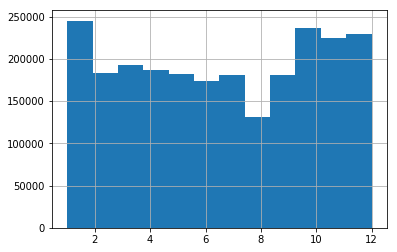

In [19]:
df_pricing_smaller.month.hist(bins=12)

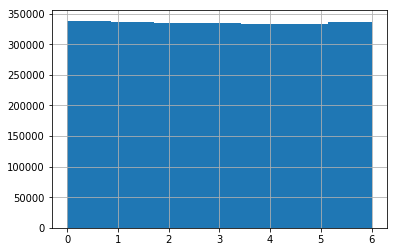

In [18]:
df_pricing_smaller.day_of_week.hist(bins=7)

### By Month by DayOfWeek Drill

In [22]:
# Group by month by day of week, and calculate an average pricing

df_pricing_by_mon_dow = df_pricing_smaller.groupby(['listing_id', 'month', 'day_of_week'])  \
                                    .price.mean()  \
                                    .reset_index()
df_pricing_by_mon_dow.head(100)

,listing_id,month,day_of_week,price
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0
5,958,1,5,185.0
6,958,1,6,180.0
7,958,2,0,179.0
8,958,2,1,179.0
9,958,2,2,179.0


In [25]:
columns2display = ['month', 'day_of_week', 'price']

df_pricing_by_mon_dow[columns2display].describe(include='all')

,month,day_of_week,price
count,625086.000000,625086.000000,625086.000000
mean,6.771691,3.008978,154.025145
std,3.570715,1.999796,97.041053
min,1.000000,0.000000,40.000000
25%,4.000000,1.000000,80.000000
50%,7.000000,3.000000,128.000000
75%,10.000000,5.000000,199.000000
max,12.000000,6.000000,500.000000


In [26]:
# Check for null values if any

df_pricing_by_mon_dow.isnull().sum()

listing_id     0
month          0
day_of_week    0
price          0
dtype: int64

In [27]:
# Rename the average price column to avoid confusion

df_pricing_by_mon_dow.rename(columns={'price':'price_by_month_dow'}, inplace=True)

In [28]:
df_pricing_by_mon_dow.shape

(625086, 4)

In [29]:
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price_by_month_dow
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


### Filter down to right data

In [ ]:
def get_month(number):
    """
    Given a number, return the name of month.
    
    """
    month_lookup = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May.', 6:'Jun.',
                    7:'Jul.', 8:'Aug.', 9:'Sep.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    
    return month_lookup[number]

In [ ]:
def get_weekdays(number):
    """
    Given a number, return the name of month.
    
    """
    weekday_lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                      4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    return weekday_lookup[number]

In [ ]:
df_pricing_by_mon_dow['month'] = df_pricing_by_mon_dow['month']  \
                                       .apply(lambda x: get_month(x))

In [ ]:
df_pricing_by_mon_dow['day_of_week'] = df_pricing_by_mon_dow['day_of_week']  \
                                             .apply(lambda x: get_weekdays(x))

In [ ]:
df_pricing_final = pd.get_dummies(df_pricing_by_mon_dow, 
                                  prefix='',
                                  prefix_sep='',
                                  columns=['month', 'day_of_week'])

In [ ]:
df_pricing_final.columns

In [ ]:
df_pricing_final.shape

In [ ]:
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

listings = pkl_file.format('df_listings_selected_features')

df_listings_features = pd.read_pickle(listings)
df_listings_features.head()

In [ ]:
df_listings_features.shape

In [ ]:
df_listings_features.columns

In [ ]:
df_final = pd.merge(left=df_pricing_final, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [ ]:
df_final.shape

In [ ]:
df_final.columns

In [ ]:
# Drop duplicate columns

df_final.drop(['id'], axis=1, inplace=True)

In [ ]:
df_final.shape

### Features with High Correlation

In [ ]:
# Create correlation matrix
# Select upper triangle of correlation matrix

corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [ ]:
# Find index of feature columns with correlation greater than 0.90

thresold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] >= thresold)]

to_drop

In [ ]:
# Drop features that have high correlation

df_final.drop(to_drop, axis=1, inplace=True)

In [ ]:
df_final.shape

## Combined Seasonality Data with Previously Identified Features

In [ ]:
file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
pkl_path = pkl_file.format('listings_seasonality')


if file_updated:
    with open(pkl_path, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(pkl_path, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(pkl_path, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [ ]:
df_final.columns

In [ ]:
df_final.select_dtypes(include =['object']).columns

In [ ]:
# Perform multiple modelings for price prediction
# This include 'listing_id', which will be used for sampling

X = df_final.drop(['price_by_month_week', 'ref_dist', 'ref_juri'], axis=1)
y = df_final.loc[:, ['listing_id', 'price_by_month_week']]

## Model Preprocessing

### Train and Test Sets Splits

In [ ]:
grp_by_listing_ids = df_final.groupby('listing_id').first().reset_index().listing_id

In [ ]:
listing_ids = list (grp_by_listing_ids)

In [ ]:
num_of_grps = len(grp_by_listing_ids)

training_ids = np.random.choice(listing_ids, int(num_of_grps*0.75), replace=False)
print(len(training_ids))
training_ids

In [ ]:
testing_ids = set(grp_by_listing_ids) - set (training_ids)
len(testing_ids)

In [ ]:
X_train = X[X['listing_id'].isin(training_ids)].drop('listing_id', axis=1)
X_test = X[X['listing_id'].isin(testing_ids)].drop('listing_id', axis=1)
y_train = y[y['listing_id'].isin(training_ids)].drop('listing_id', axis=1).values.ravel()
y_test = y[y['listing_id'].isin(testing_ids)].drop('listing_id', axis=1).values.ravel()

print(len(X_train), len(X_test), len(y_train), len(y_test))

### Feature Normalization

In [ ]:
ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

In [ ]:
# Model-LR

model=sm.OLS(y_train, sm.add_constant(X_train_trans))
fit=model.fit()
fit.summary()

## Random Forest

In [ ]:
# Model-Random Forest

rf = RandomForestRegressor(n_estimators=100, 
                           criterion='mse', 
                           random_state=42, 
                           verbose=1,
                           n_jobs=-1)
rf.fit(X_train_trans, y_train.ravel())

y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

In [ ]:
df_final.listing_id.nunique()

In [ ]:
# Double check on price range. The range is as expected

y.describe(include='all')

In [ ]:
# Map feature importance with labels

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

In [ ]:
# Order features based on importance

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)
feature_lists

In [ ]:
features = [list_[0] for list_ in feature_lists]
features

In [ ]:
# 'ref_dist', 'ref_juri', 'ref_jurisdiction', 'price_by_month_week'


columns =['listing_id']
columns.extend(features)
columns.extend(['ref_dist', 'ref_juri', 'price_by_month_week'])

In [ ]:
df_data = df_final[columns]
df_data.head()

In [ ]:
df_data.shape

In [ ]:
df_data.rename(columns={'price_by_month_week':'price'}, inplace=True)

In [ ]:
df_data.isnull().sum()

In [ ]:
temp_df = df_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].copy()

days = temp_df.apply(lambda x: x.idxmax(), axis=1)
days

In [ ]:
csv_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

csv_path = csv_file.format('airbnb_data')

df_data.to_csv(csv_path)

In [ ]:
# This is to create visual to show seasonality

df_visual = pd.merge(left=df_pricing_by_month_weekday, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [ ]:
# df_visual = df_final.copy()

In [ ]:
df_visual.shape

In [ ]:
df_visual.columns

In [ ]:
df_visual_entire_apartment = df_visual[df_visual['room_type_Entire home/apt']==1 ]
df_visual_single_room = df_visual[df_visual['room_type_Entire home/apt']!=1 ]

print(df_visual_entire_apartment.shape, df_visual_single_room.shape )

In [ ]:
df_visual_entire_apartment.ref_dist.describe

In [ ]:
df_visual_entire_apartment_sf = df_visual_entire_apartment[df_visual_entire_apartment['ref_dist']=='San Francisco']
df_visual_entire_apartment_scz = df_visual_entire_apartment[df_visual_entire_apartment['ref_dist']=='Santa Clara']

print(df_visual_entire_apartment_sf.shape, df_visual_entire_apartment_scz.shape )

In [ ]:
df_visual_entire_apartment_sf.listing_id.nunique()

In [ ]:
df_visual_entire_apartment_scz.listing_id.nunique()

In [ ]:
# Weekly pattern for entire apartment

df_week_entire_apartment = df_visual_entire_apartment.groupby(['ref_dist', 'day_of_week'])  \
                                                     .price_by_month_week.mean()
df_week_entire_apartment

In [ ]:
# Weekly pattern for single room

df_week_single_room = df_visual_single_room.groupby(['ref_dist', 'day_of_week'])  \
                                           .price_by_month_week.mean()
df_week_single_room

In [ ]:
# Montly Pattern for entire apartment

df_visual_entire_apartment.groupby(['ref_dist', 'month']).price_by_month_week.mean()

In [ ]:
# Montly Pattern for single room

df_visual_single_room.groupby(['ref_dist', 'month']).price_by_month_week.mean()